In [ ]:
# install bertopic
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from bertopic import BERTopic
import gensim.corpora as corpora
from pprint import pprint
import nltk
import pandas as pd
from nltk.corpus import stopwords
import spacy
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **BERTopic analysis for English data**

In [ ]:
# input the English data
df_English = pd.read_csv("/content/lifelong learning_English.csv")


# delate the NA abstracts
df_English.dropna(subset=['Abstract'], inplace=True)
df_English['Abstract'] = df_English['Abstract'].astype(str)   # transfer 'Abstract' into strings

# define a function for tokenization
def count_tokens(text):
  return len(nltk.word_tokenize(text))

# calculate the token numbers in 'Abstract'
df_English['Token Count'] = df_English['Abstract'].apply(count_tokens)

# filter datapoints where the token numbers are less than 24
df = df_English[df_English['Token Count'] >= 24]

# remove the created 'Token Count' column
df = df.drop(columns=['Token Count'])
df.head(5)

,Publication Type,Authors,Book Authors,Book Editors,Author Full Names,Book Author Full Names,Article Title,Source Title,Book Series Title,Abstract,Publication Year,Volume,Issue,Start Page,End Page
0,J,"Schrock, JW; Cydulka, RK",NaN,NaN,"Schrock, Jon W.; Cydulka, Rita K.",NaN,Lifelong learning,EMERGENCY MEDICINE CLINICS OF NORTH AMERICA,NaN,Early American physician education lacked qual...,2006,24.0,3,785,+
1,J,"BELANGER, P",NaN,NaN,"BELANGER, P",NaN,LIFELONG LEARNING - THE DIALECTICS OF LIFELONG...,INTERNATIONAL REVIEW OF EDUCATION,NaN,This article examines the emergence of differe...,1994,40.0,3-5,353,381
2,C,"Bostan, CG",NaN,"Vasile, C","Bostan, Carmen-Gabriela",NaN,Emergencies in lifelong learning,ADULT EDUCATION IN UNIVERSITIES: LOCAL AND REG...,Procedia Social and Behavioral Sciences,"25 years after the revolution, there are more ...",2014,142.0,NaN,268,273
3,B,"Al Mosawi, AJ",NaN,"Caltone, MP","Al Mosawi, Aamir Jalal",NaN,LIFELONG LEARNING FOR PHYSICIANS,HANDBOOK OF LIFELONG LEARNING DEVELOPMENTS,Education in a Competitive and Globalizing World,Introduction The primary concept of lifelong l...,2010,NaN,NaN,213,237
4,J,"Cuffy, V; Tribe, J; Airey, D",NaN,NaN,"Cuffy, Violet; Tribe, John; Airey, David",NaN,LIFELONG LEARNING FOR TOURISM,ANNALS OF TOURISM RESEARCH,NaN,This paper examines the provision of education...,2012,39.0,3,1402,1424


In [ ]:
# remove stopwords

# import the stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('lifelong')
stop_words.add('education')
stop_words.add('learn')
stop_words.add('learning')
# define a function to remove stopwords
def remove_stopwords(abstract):
  # convert all strings into lowercases
  abstract_lower = abstract.lower()

  # tokenization
  words = nltk.word_tokenize(abstract_lower)

  # remove stopwords
  text_removed = [word for word in words if word not in stop_words]

  # return the processed texts
  return text_removed

processed_abstract_list = []
for each_abstract in df['Abstract']:
  processed_abstract = remove_stopwords(each_abstract)
  processed_abstract_list.append(processed_abstract)

processed_stringformat = [' '.join(map(str, lst)) for lst in processed_abstract_list]

In [ ]:
# Load the English model
nlp = spacy.load('en_core_web_sm')
# a new list for lemmatized sentences
lemmatized_sentence = []
for each_sentence in processed_stringformat:
  lemmatized_words_list = []
  each_doc = nlp(each_sentence)
  for token in each_doc:
    if token.pos_ in ('NOUN', 'ADV', 'PROPN', 'VERB', 'ADJ'):
      lemmatized_words_list.append(token.lemma_)
  lemmatized_sentence.append(' '.join(lemmatized_words_list))

In [ ]:
len(lemmatized_sentence)

# In total, we have 979 rows of data.

1054

In [ ]:
# Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Reduce dimensionality
umap_model = UMAP(n_neighbors=100, n_components=10, min_dist=0.0, metric='cosine')

# Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# we add this to remove stopwords and set the N-gram range
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")

# Create topic representation
ctfidf_model = ClassTfidfTransformer()

# set the hyperparameters of topic model
# All steps together
topic_model = BERTopic(
  language='English',
  min_topic_size=10,
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model
  )

In [ ]:
# train the model

topics, probs = topic_model.fit_transform(lemmatized_sentence)

2023-08-06 11:08:01,755 - BERTopic - Transformed documents to Embeddings
2023-08-06 11:08:10,167 - BERTopic - Reduced dimensionality
2023-08-06 11:08:10,223 - BERTopic - Clustered reduced embeddings


In [ ]:
freq = topic_model.get_topic_info(); freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,468,-1_study_student_research_development,"[study, student, research, development, adult,...",[relevance research involve outline need moder...
1,0,207,0_policy_development_european_social,"[policy, development, european, social, paper,...",[modern educational policy main purpose buildi...
2,1,102,1_medical_physician_practice_professional,"[medical, physician, practice, professional, c...",[board certification movement found concern qu...
3,2,71,2_teacher_teaching_study_professional,"[teacher, teaching, study, professional, resea...",[become main educational policy european union...
4,3,69,3_technology_use_student_learner,"[technology, use, student, learner, base, envi...",[game base virtual environment tailor diversif...
5,4,36,4_project_student_university_course,"[project, student, university, course, develop...",[today society student graduate demand equip f...
6,5,34,5_old_age_old adult_adult,"[old, age, old adult, adult, senior, elderly, ...",[encourage successful age label stereotypical ...
7,6,34,6_student_self_study_tendency,"[student, self, study, tendency, skill, univer...",[competence consider article integrate ability...
8,7,18,7_music_art_musical_therapy,"[music, art, musical, therapy, child, adult, a...",[lie foundation musical practice parent feel c...
9,8,15,8_qualification_effect_level_formal,"[qualification, effect, level, formal, individ...",[recent decade international organization deve...


In [ ]:
# the default labels for each topic
topic_model.topic_labels_

{-1: '-1_study_student_development_research',
 0: '0_policy_development_adult_social',
 1: '1_medical_physician_practice_professional',
 2: '2_teacher_teaching_study_professional',
 3: '3_use_technology_learner_student',
 4: '4_student_self_study_tendency',
 5: '5_project_student_university_course',
 6: '6_old_age_old adult_adult',
 7: '7_music_art_musical_therapy',
 8: '8_low_formal_training_job'}

In [ ]:
# the size of each topic
topic_model.topic_sizes_

Counter({1: 97,
         -1: 488,
         7: 20,
         0: 204,
         6: 29,
         8: 15,
         4: 37,
         3: 54,
         2: 73,
         5: 37})

In [ ]:
# visualize Topics
topic_model.visualize_topics()

In [ ]:
# visualize topic hierarchy
topic_model.visualize_hierarchy(top_n_topics=10)

In [ ]:
topic_model.visualize_barchart(top_n_topics=8)

In [ ]:
for i in range(9):
  print(i)
  print(topic_model.get_topic(i))

0
[('policy', 0.018530664405915123), ('development', 0.012687139186799368), ('european', 0.011331697944707324), ('social', 0.0109478621332463), ('paper', 0.010868242073724681), ('adult', 0.010382215019356374), ('economic', 0.009680959090507646), ('country', 0.009543483525239562), ('article', 0.009022523270769328), ('international', 0.008211000416010424)]
1
[('medical', 0.02524977044118492), ('physician', 0.01814113670773944), ('practice', 0.016878173417179114), ('professional', 0.014489591679904363), ('clinical', 0.01345104544355262), ('nurse', 0.01275322001601184), ('continue', 0.012266356553243067), ('use', 0.011368938163079488), ('care', 0.00952605921491881), ('graduate', 0.008758047375064271)]
2
[('teacher', 0.06912739535341264), ('teaching', 0.01885328304785288), ('study', 0.01854231706176843), ('professional', 0.017607916806682167), ('research', 0.013719097914588422), ('development', 0.013005305389438436), ('use', 0.012875994853744518), ('teach', 0.01258703724317689), ('school', 

In [ ]:
# similarity heatmap
topic_similar_heatmap = topic_model.visualize_heatmap(n_clusters=8)
topic_similar_heatmap.write_html('topic_similar_heatmap.html')
topic_similar_heatmap

### **LDA analysis for English data**

In [ ]:
# from the sentence to sublists containing words

def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

In [ ]:
# build the N-gram models
bigram = gensim.models.Phrases(lemmatized_sentence, min_count=5, threshold=30)
trigram = gensim.models.Phrases(bigram[lemmatized_sentence], threshold=30)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [ ]:
lda_data = lemmatized_sentence
data_words = list(sent_to_words(lda_data))
print(data_words[:1])

[['early', 'american', 'physician', 'lack', 'quality', 'consistency', 'poorly', 'fund', 'institution', 'weak', 'curricula', 'little', 'patient', 'contact', 'graduation', 'train', 'early', 'doctor', 'advent', 'twentieth', 'century', 'reformation', 'medical', 'take', 'place', 'create', 'foundation', 'modem', 'american', 'medical', 'system', 'importance', 'physician', 'increase', 'lead', 'production', 'specialty', 'board', 'requirement', 'continue', 'medical', 'culminate', 'continuous', 'certification', 'process', 'require', 'specialty', 'include', 'american', 'board', 'emergency', 'medicine', 'utility', 'continue', 'medical', 'question', 'technological', 'advance', 'internet', 'improve', 'technique', 'help', 'physician', 'practice', 'modem', 'medicine', 'time', 'rapidly', 'expand', 'science']]


In [ ]:
processed_data = process_words(data_words)
processed_data[:1]

[['early',
  'american',
  'physician',
  'lack',
  'quality',
  'consistency',
  'poorly',
  'fund',
  'institution',
  'weak',
  'curricula',
  'little',
  'patient',
  'contact',
  'graduation',
  'train',
  'early',
  'doctor',
  'advent',
  'twentieth',
  'reformation',
  'medical',
  'take',
  'place',
  'create',
  'foundation',
  'medical',
  'system',
  'importance',
  'physician',
  'increase',
  'lead',
  'production',
  'specialty',
  'board',
  'requirement',
  'continue',
  'medical',
  'culminate',
  'continuous',
  'certification',
  'process',
  'require',
  'specialty',
  'include',
  'medicine',
  'utility',
  'continue',
  'medical',
  'question',
  'technological',
  'advance',
  'internet',
  'improve',
  'technique',
  'help',
  'physician',
  'practice',
  'modem',
  'medicine',
  'time',
  'rapidly',
  'expand',
  'science']]

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(processed_data)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_data]


In [37]:
# Build LDA model
from pprint import pprint
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=10,
                        random_state=100,
                        update_every=1,
                        chunksize=10,
                        passes=10,
                        alpha='symmetric',
                        iterations=1000,
                        per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.040*"individual" + 0.037*"significant" + 0.036*"public" + 0.036*"job" + '
  '0.035*"cognitive" + 0.033*"community" + 0.028*"medium" + 0.020*"music" + '
  '0.020*"perform" + 0.018*"material"'),
 (1,
  '0.000*"gept" + 0.000*"dental" + 0.000*"au" + 0.000*"smartphone" + '
  '0.000*"house" + 0.000*"rigor" + 0.000*"apprentissage" + '
  '0.000*"conservatory" + 0.000*"castilla" + 0.000*"motivator"'),
 (2,
  '0.078*"study" + 0.070*"teacher" + 0.045*"also" + 0.026*"school" + '
  '0.025*"apply" + 0.016*"pedagogical" + 0.015*"tendency" + 0.015*"teaching" + '
  '0.015*"test" + 0.013*"faculty"'),
 (3,
  '0.051*"year" + 0.035*"people" + 0.029*"specific" + 0.026*"ability" + '
  '0.025*"local" + 0.024*"language" + 0.022*"individual" + 0.019*"country" + '
  '0.019*"international" + 0.018*"authority"'),
 (4,
  '0.045*"practice" + 0.040*"medical" + 0.034*"make" + 0.027*"old" + '
  '0.027*"increase" + 0.023*"graduate" + 0.022*"identify" + 0.019*"cultural" + '
  '0.019*"science" + 0.015*"quality"'

In [35]:
coherence = []
for k in range(1,25):
    print('Round: '+str(k))
    ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                            id2word=id2word,
                            num_topics=k,
                            random_state=100,
                            update_every=1,
                            chunksize=10,
                            passes=10,
                            alpha='symmetric',
                            iterations=1000,
                            per_word_topics=True)


    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel,
                              texts=processed_data,
                              dictionary=id2word,
                              coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


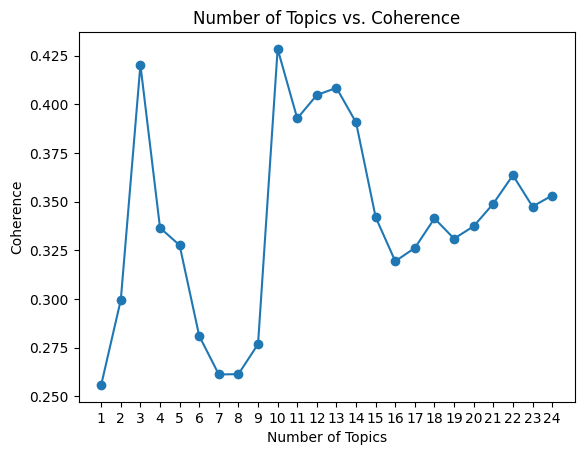

In [36]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [ ]:
# Dominant topic and its percentage contribution

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=processed_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=processed_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.7766,"practice, medical, make, old, increase, organi...","[early, american, physician, lack, quality, co..."
1,1,6,0.9888,"study, skill, knowledge, development, training...","[examine, emergence, different, pattern, time,..."
2,2,0,0.4676,"individual, year, people, policy, ability, sig...","[year, revolution, people, leave, school, earl..."
3,3,7,0.7361,"professional, course, program, activity, new, ...","[introduction, primary, concept, person, oppor..."
4,4,6,0.9585,"study, skill, knowledge, development, training...","[paper, examine, provision, training, tourism,..."


In [ ]:
# The most representative sentence for each topic

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                            grp.sort_values(['Perc_Contribution'],
                                      ascending=False).head(1)],
                                      axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.4676,"individual, year, people, policy, ability, significant, public, job, challenge, country","[year, revolution, people, leave, school, early, job, profession, constitute, danger, society, e..."
1,1,0.6479,"use, result, self, analysis, level, experience, technology, information, aim, model","[aim, determine, academician, perception, competency, accord, various, variable, sample, compose..."
2,2,0.6250,"study, teacher, also, school, motivation, tendency, test, vocational, faculty, teaching","[main, essence, study, introduce, also, engineering, pedagogy, issue, refer, engineering, pedago..."
3,3,0.3812,"specific, language, authority, action, year, open, curriculum, access, culture, foreign","[establish, concept, international, discourse, surround, imply, globally, relevant, nevertheless..."
4,4,0.7766,"practice, medical, make, old, increase, organization, graduate, identify, cultural, science","[early, american, physician, lack, quality, consistency, poorly, fund, institution, weak, curric..."
5,5,0.8022,"student, research, base, programme, high, scale, well, university, institution, part","[pose, large, number, threat, opportunitie, traditional, high, institution, programme, offer, me..."
6,6,0.9888,"study, skill, knowledge, development, training, social, need, educational, paper, adult","[examine, emergence, different, pattern, time, give, overall, view, various, contribution, speci..."
7,7,0.7361,"professional, course, program, activity, new, age, context, employee, work, manager","[introduction, primary, concept, person, opportunitie, age, numerous, context, work, home, leisu..."
